In [1]:
import sqlite3

import numpy as np
import pandas as pd

import scipy.stats as scs
from statsmodels.stats.power import tt_ind_solve_power

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cursor = conn.cursor()

In [3]:
def get_table(conn=conn, table='Employee'):
    df = pd.read_sql(f'select * from {table}', conn)
    return df


from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

In [4]:
cursor.execute('select name from sqlite_master where type="table"').fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

# Q1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?


### Obtain the data for the question

In [5]:
df = get_table(table='OrderDetail')
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


### Split up our data by has_discount

In [6]:
df['has_discount'] = [1 if d > 0 else 0 for d in df.Discount]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,has_discount
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


### Let's do some basic EDA before we hypothesis test

In [7]:
discounted_vals = df.loc[df['has_discount']>0, 'Quantity']
non_discounted_vals = df.loc[df['has_discount']==0, 'Quantity']

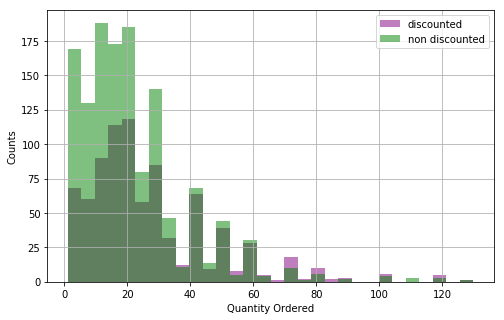

In [8]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.hist(discounted_vals.values, label='discounted', bins=30, color='purple', alpha=0.5)
plt.hist(non_discounted_vals.values, label='non discounted', bins=30, color='g', alpha=0.5)
plt.legend()
plt.xlabel("Quantity Ordered")
plt.ylabel("Counts")
plt.show()

Eyeballing this, they look fairly similar, skewed to the left.  

#### Test this using an indepedent Ttest

Assumptions
- is our data normally distributed
    - shapiro
- are their variances equal
    - levene

In [9]:
def test_normality(x):
    t, p = scs.shapiro(x)
    if p < 0.05:
        print(f"p = {p}\nTherefore the data is not normal")
        return False
    print(f"p = {p}\nTherefore the data is normal")
    return True


def test_equal_variances(x1, x2):
    """
    h0: var_x1 = var_x2
    ha: var_x1 != var_x2
    """
    t, p = scs.levene(x1, x2)
    if p < 0.05:
        print(f"p = {p}\nTherefore the data do not have equal variances")
        return False
    print(f"p = {p}\nTherefore the data have equal variances")
    return True

In [10]:
# Assumption 1 - our data is normally distributed
# H0: the data was drawn from a normal distribution.
# HA: the data was drawn from a non-normal distribution.
# pvalue > 0.05 -> fail to reject the null -> normal

test_normality(discounted_vals)
test_normality(non_discounted_vals)

p = 6.88120409395894e-26
Therefore the data is not normal
p = 3.803856556577728e-34
Therefore the data is not normal


False

### Our data is not normal! So what do we do? 
Take a sampling distribution of the means

In [11]:
# let's take a sampling distribution of the mean quantity
discounted_sample_means = []
non_discounted_sample_means = []


for i in range(30):
    # what kind of sampling is this? Bootstrap Sampling
    dis_samp = np.random.choice(discounted_vals, size=discounted_vals.shape[0], replace=True).mean()
    discounted_sample_means.append(dis_samp)
    
    non_dis_samp = np.random.choice(non_discounted_vals, size=non_discounted_vals.shape[0], replace=True).mean()
    non_discounted_sample_means.append(non_dis_samp)

In [12]:
test_normality(discounted_sample_means)
test_normality(non_discounted_sample_means)

p = 0.1761559098958969
Therefore the data is normal
p = 0.2854227125644684
Therefore the data is normal


True

### Now test our other assumption for equal variances

In [13]:
test_equal_variances(discounted_sample_means, non_discounted_sample_means)

p = 0.04114854778056398
Therefore the data do not have equal variances


False

### let's plot the sampling distributions just to eyeball it


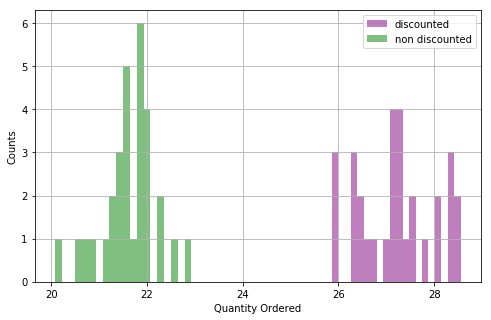

In [14]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.hist(discounted_sample_means, label='discounted', bins=20, color='purple', alpha=0.5)
plt.hist(non_discounted_sample_means, label='non discounted', bins=20, color='g', alpha=0.5)
plt.legend()
plt.xlabel("Quantity Ordered")
plt.ylabel("Counts")
plt.show()

### Let's run our TTest
* H0: mu_1 = mu_2
* HA: mu_1 != mu_2

In [15]:
scs.ttest_ind(discounted_sample_means, non_discounted_sample_means)

Ttest_indResult(statistic=30.595498720178167, pvalue=1.758314121708753e-37)

In [16]:
scs.ttest_ind(discounted_sample_means, non_discounted_sample_means, equal_var=False)

Ttest_indResult(statistic=30.595498720178167, pvalue=5.038362375481306e-35)

Given a p-value of 0 this means that our means are not equal and we **reject the null hypothesis, H0**

### Let's run a simulation on this using the mean and sample standard deviation

In [17]:
dis_mu = np.mean(discounted_sample_means)
dis_std = np.std(discounted_sample_means, ddof=1)

non_dis_mu = np.mean(non_discounted_sample_means)
non_dis_std = np.std(non_discounted_sample_means, ddof=1)

In [18]:
dis_samp = np.random.normal(loc=dis_mu, scale=dis_std, size=50)
non_dis_samp = np.random.normal(loc=non_dis_mu, scale=non_dis_std, size=50)

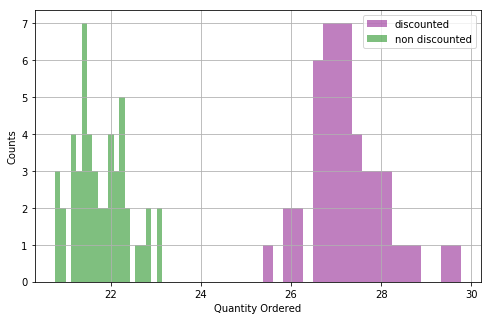

In [19]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.hist(dis_samp, label='discounted', bins=20, color='purple', alpha=0.5)
plt.hist(non_dis_samp, label='non discounted', bins=20, color='g', alpha=0.5)
plt.legend()
plt.xlabel("Quantity Ordered")
plt.ylabel("Counts")
plt.show()

In [20]:
scs.ttest_ind(dis_samp, non_dis_samp, equal_var=True)

Ttest_indResult(statistic=38.18054785119899, pvalue=1.2134590428681277e-60)

In [21]:
effect_size = cohen_d(discounted_sample_means, non_discounted_sample_means)
effect_size

7.899723800810692

In [22]:
power = tt_ind_solve_power(effect_size=effect_size, nobs1=100, alpha=0.5)
power

1.0

Discounts have an effects size of **9.22** which massive. So, therefore, we can conclude that the discounts do effect the quantity ordered. 

### Run tests on data divided by discount level